In [62]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.preprocessing import StandardScaler, MinMaxScaler  
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score,confusion_matrix,classification_report, precision_score, recall_score
from sklearn import metrics, linear_model
from sklearn.tree import DecisionTreeClassifier 
from sklearn.decomposition import PCA 

import plotly
import plotly.graph_objects as go
from plotly.offline import plot

import numpy as np
from numpy import mean

import time
from datetime import datetime
import datetime

import statistics

import random
import itertools
import json

from get_information_sprottenflotte import get_station_of_kiel, get_returning, get_renting

pd.options.mode.chained_assignment = None  # default='warn'

In [63]:
from weather_functions import *

Preprocessing of the weather data: we drop some attributes of which we think that they don't have much influence on the usage of bikes and we filter the days for the next analysis. After that we transform the categorical attribute to numerical and clean the raw data from noise data.

In [64]:
# read the weather data from the CSV data
weather_df = pd.read_csv('data/weather_data.csv')

# keep the interesting attributes of the weather
new_weather_df = weather_df[['timestamp', 'Precipitation', 'Condition', 'Sunshine', 'Temperature','wind_speed']]

# make a dataframe with just the daytimes
weather_day_original = new_weather_df.loc[new_weather_df["timestamp"].apply(lambda x: x[11:16] >= '06:00' and x[11:16] < '22:00' )] 
weather_day_original = weather_day_original.reset_index(drop=True)

weather_day_original.head()

,timestamp,Precipitation,Condition,Sunshine,Temperature,wind_speed
0,2023-03-03T06:00:00+00:00,0.0,fog,0.0,0.2,9.7
1,2023-03-03T06:30:00+00:00,0.0,fog,0.0,0.3,6.8
2,2023-03-03T07:00:00+00:00,0.0,fog,0.0,0.3,9.0
3,2023-03-03T07:30:00+00:00,0.0,fog,0.0,0.3,6.1
4,2023-03-03T08:00:00+00:00,0.0,fog,0.0,0.4,7.6


In [65]:
#transform the categorical variable 'Condition' in a numerical variable
weather_day = weather_day_original.replace('dry', 4)
weather_day = weather_day.replace('fog', 3)
weather_day = weather_day.replace('snow', 2)
weather_day = weather_day.replace('rain', 1)
weather_day = weather_day.replace('sleet', 0)

weather_day.head()

,timestamp,Precipitation,Condition,Sunshine,Temperature,wind_speed
0,2023-03-03T06:00:00+00:00,0.0,3,0.0,0.2,9.7
1,2023-03-03T06:30:00+00:00,0.0,3,0.0,0.3,6.8
2,2023-03-03T07:00:00+00:00,0.0,3,0.0,0.3,9.0
3,2023-03-03T07:30:00+00:00,0.0,3,0.0,0.3,6.1
4,2023-03-03T08:00:00+00:00,0.0,3,0.0,0.4,7.6


'Weather_day' is the dataframe with the cleaned weather data:

In [66]:
list_of_noise, weather_day = find_noise_in_timestamp(weather_day)
weather_day.head()

,timestamp,Precipitation,Condition,Sunshine,Temperature,wind_speed
0,2023-03-03T06:00:00+00:00,0.0,3,0.0,0.2,9.7
1,2023-03-03T06:30:00+00:00,0.0,3,0.0,0.3,6.8
2,2023-03-03T07:00:00+00:00,0.0,3,0.0,0.3,9.0
3,2023-03-03T07:30:00+00:00,0.0,3,0.0,0.3,6.1
4,2023-03-03T08:00:00+00:00,0.0,3,0.0,0.4,7.6


Load the sprottenflotte-data.

In [67]:
#Loading the sprottenflotte data
sf_df = pd.read_csv('data/sprottenflotte_data.csv')
sf_df.head()

,Station_ID,Number_of_Bikes,Number_of_Docks_Available,is_installed,is_renting,is_returning,last_reported,last_update
0,24371,23,78,1,1,1,1677792158,1677802253
1,24464,18,23,1,1,1,1677781956,1677802253
2,24384,0,40,1,1,1,1677777220,1677802253
3,24424,17,23,1,1,1,1677795538,1677802253
4,24468,2,17,1,1,1,1677687849,1677802253


We just want to observe the data of the stations Kiel. So we want to drop the stations which aren't in Kiel.

In [68]:
#make a datframe with lat and lon to get stations of Kiel
sf_names_df = pd.read_csv('general_data/sprottenflotte_station_information.csv')
sf_df_with_lat_lon = pd.merge(sf_df, sf_names_df, on ="Station_ID")


#dataframe from before but just stations of Kiel
sf_kiel = get_station_of_kiel(sf_df_with_lat_lon)


#list of station_IDs of Kiel
list_kiel_station = pd.unique(sf_kiel['Station_ID'])

sf_kiel.head()

,Station_ID,Number_of_Bikes,Number_of_Docks_Available,is_installed,is_renting,is_returning,last_reported,last_update,Unnamed: 0,name,lat,lon,region_id,address,post_code
0,24371,23,78,1,1,1,1677792158,1677802253,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
1,24371,23,78,1,1,1,1677792158,1677802529,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
2,24371,23,78,1,1,1,1677792158,1677802835,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
3,24371,23,78,1,1,1,1677792158,1677803141,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
4,24371,23,78,1,1,1,1677792158,1677803445,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN


In [69]:
#copy the Sprottenflotte-dataframe to apply the convert_data, so we have a dataframe with "normal" timestamps
sf_time = sf_kiel[:]
sf_time['last_update'] = sf_time['last_update'].apply(datetime.utcfromtimestamp)
sf_time['last_reported'] = sf_time['last_reported'].apply(datetime.utcfromtimestamp)

sf_time.head()

,Station_ID,Number_of_Bikes,Number_of_Docks_Available,is_installed,is_renting,is_returning,last_reported,last_update,Unnamed: 0,name,lat,lon,region_id,address,post_code
0,24371,23,78,1,1,1,2023-03-02 21:22:38,2023-03-03 00:10:53,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
1,24371,23,78,1,1,1,2023-03-02 21:22:38,2023-03-03 00:15:29,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
2,24371,23,78,1,1,1,2023-03-02 21:22:38,2023-03-03 00:20:35,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
3,24371,23,78,1,1,1,2023-03-02 21:22:38,2023-03-03 00:25:41,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
4,24371,23,78,1,1,1,2023-03-02 21:22:38,2023-03-03 00:30:45,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN


In [70]:
#make a dataframe with just the day-times (like the weather data)
sf_day = sf_time.loc[sf_time["last_update"].apply(lambda x: x.hour >= 6 and x.hour <= 21 )] 
sf_day = sf_day.reset_index(drop=True)
sf_day.head()

,Station_ID,Number_of_Bikes,Number_of_Docks_Available,is_installed,is_renting,is_returning,last_reported,last_update,Unnamed: 0,name,lat,lon,region_id,address,post_code
0,24371,25,76,1,1,1,2023-03-03 05:39:08,2023-03-03 06:02:03,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
1,24371,25,76,1,1,1,2023-03-03 05:39:08,2023-03-03 06:07:08,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
2,24371,25,76,1,1,1,2023-03-03 05:39:08,2023-03-03 06:12:13,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
3,24371,25,76,1,1,1,2023-03-03 05:39:08,2023-03-03 06:17:18,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
4,24371,25,76,1,1,1,2023-03-03 05:39:08,2023-03-03 06:21:53,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN


In [71]:
# make the same dataframe with data from Kiel and just the days but with the UNIX-datetime again
sf_day_next = sf_kiel.loc[sf_time["last_update"].apply(lambda x: x.hour >= 6 and x.hour <= 21 )] 
sf_day_next = sf_day_next.reset_index(drop=True)

sf_day_next.head()

,Station_ID,Number_of_Bikes,Number_of_Docks_Available,is_installed,is_renting,is_returning,last_reported,last_update,Unnamed: 0,name,lat,lon,region_id,address,post_code
0,24371,25,76,1,1,1,1677821948,1677823323,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
1,24371,25,76,1,1,1,1677821948,1677823628,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
2,24371,25,76,1,1,1,1677821948,1677823933,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
3,24371,25,76,1,1,1,1677821948,1677824238,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN
4,24371,25,76,1,1,1,1677821948,1677824513,27,Anleger Reventlou,54.333833,10.15225,866,",",NaN


Now we get the information about the stations as follows: renting numbers, returning numbers, usage numbers, number of bikes at a stations. Each of the information we take for half an hour to match them to the weather data. After that we sum up the information of every station to get a list of the numbers of all stations in every half hour.

In [72]:
dicto_of_number_bikes = avg_number_of_bike_per_half_hour(sf_day_next)
dicto_of_number_bikes

{24371: [24.833333333333332,
  25.5,
  28.0,
  30.0,
  33.0,
  33.0,
  33.0,
  33.0,
  33.0,
  33.5,
  33.333333333333336,
  33.0,
  31.166666666666668,
  30.333333333333332,
  30.833333333333332,
  32.0,
  33.166666666666664,
  34.833333333333336,
  32.666666666666664,
  30.5,
  30.833333333333332,
  29.666666666666668,
  26.666666666666668,
  26.166666666666668,
  24.666666666666668,
  22.0,
  20.0,
  20.0,
  20.5,
  23.0,
  23.0,
  23.0,
  24.0,
  24.5,
  24.166666666666668,
  24.0,
  24.0,
  24.0,
  25.5,
  25.0,
  25.0,
  25.0,
  23.0,
  21.0,
  21.0,
  21.0,
  21.5,
  27.0,
  27.666666666666668,
  33.0,
  35.166666666666664,
  36.666666666666664,
  26.833333333333332,
  26.0,
  27.5,
  28.0,
  27.666666666666668,
  27.166666666666668,
  27.0,
  27.0,
  27.0,
  27.666666666666668,
  28.0,
  28.0,
  28.0,
  27.333333333333332,
  28.0,
  27.5,
  27.0,
  28.0,
  28.0,
  29.833333333333332,
  30.833333333333332,
  30.0,
  30.333333333333332,
  31.666666666666668,
  30.666666666666668,

In [73]:
# sum up the number of bikes of every station
list_of_number_bikes = sum_up_funtion(dicto_of_number_bikes, sf_day)

In [ ]:
dict_of_using = usage_of_station_per_half_hour(sf_day_next)
dict_of_using

In [ ]:
# sum up the usage of bikes of every station
list_of_all_use = sum_up_funtion(dict_of_using, sf_day)
#list_of_all_use

In [ ]:
dict_of_returning = returning_bike_of_station_per_half_hour(sf_day_next)
dict_of_returning

In [ ]:
list_of_all_return = sum_up_funtion(dict_of_returning, sf_day)
list_of_all_return

In [ ]:
dict_of_renting = renting_bike_of_station_per_half_hour(sf_day_next)
dict_of_renting

{24371: [1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  2,
  2,
  4,
  1,
  0,
  2,
  3,
  2,
  1,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  3,
  2,
  0,
  2,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  4,
  0,
  0,
  1,
  0,
  1,
  1,
  2,
  1,
  3,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  2,
  0,
  0,
  0,
  0,
  1,
  1,
  2,
  0,
  2,
  1,
  0,
  0,
  0,
  2,
  1,
  3,
  4,
  2,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  1,
  1,
  0,
  5,
  2,
  0,
  2,
  4,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  4,
  1,
  4,
  2,
  0,
  1,
  2,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  3,
  0,
  1

In [ ]:
list_of_all_rent = sum_up_funtion(dict_of_renting, sf_day)

We are doing one last data cleaning step: 
Some timeslots are missing in the Sprottenflotte data. Thats why we need to drop them in the weather data as well.

In [ ]:
weather_and_sf_day_original = weather_day[:]

# "Data Cleaning"
# drop the timeslots in which the sf data doesn't have data
weather_and_sf_day_original = weather_and_sf_day_original.loc[(weather_and_sf_day_original['timestamp'] != '2023-03-07T09:00:00+00:00') & (weather_and_sf_day_original['timestamp'] != '2023-03-08T08:00:00+00:00') & (weather_and_sf_day_original['timestamp'] != '2023-03-08T08:10:00+00:00')]
#weather_and_sf_day_original = weather_and_sf_day_original.drop([161])
weather_and_sf_day_original = weather_and_sf_day_original.reset_index(drop=True)

weather_and_sf_day_original[380:400]
weather_and_sf_day_original = weather_and_sf_day_original.drop(index = [382, 383, 384, 385, 386, 387, 388, 389])

In [ ]:
time_of_weather = weather_and_sf_day_original['timestamp'].to_list()
weather_and_sf_day_original = weather_and_sf_day_original.reset_index(drop=True)
weather_and_sf_day_original.head()

,timestamp,Precipitation,Condition,Sunshine,Temperature,wind_speed
0,2023-03-03T06:00:00+00:00,0.0,3,0.0,0.2,9.7
1,2023-03-03T06:30:00+00:00,0.0,3,0.0,0.3,6.8
2,2023-03-03T07:00:00+00:00,0.0,3,0.0,0.3,9.0
3,2023-03-03T07:30:00+00:00,0.0,3,0.0,0.3,6.1
4,2023-03-03T08:00:00+00:00,0.0,3,0.0,0.4,7.6


Combine weather and sf data.

In [ ]:
# make new columns in the weather data for the bike data
weather_and_sf_day = weather_and_sf_day_original[:]

weather_and_sf_day['average use'] = list_of_all_use
weather_and_sf_day['number of bikes'] = list_of_number_bikes
weather_and_sf_day['rented bikes'] = list_of_all_rent
weather_and_sf_day['returned bikes'] = list_of_all_return

weather_and_sf_day.head()

,timestamp,Precipitation,Condition,Sunshine,Temperature,wind_speed,average use,number of bikes,rented bikes,returned bikes
0,2023-03-03T06:00:00+00:00,0.0,3,0.0,0.2,9.7,89,448.000000,7,3
1,2023-03-03T06:30:00+00:00,0.0,3,0.0,0.3,6.8,98,444.333333,12,13
2,2023-03-03T07:00:00+00:00,0.0,3,0.0,0.3,9.0,101,444.833333,12,12
3,2023-03-03T07:30:00+00:00,0.0,3,0.0,0.3,6.1,117,435.500000,23,21
4,2023-03-03T08:00:00+00:00,0.0,3,0.0,0.4,7.6,104,450.666667,12,23


Doing some observations on the data to find out if there are some correlations or other patterns.

<Axes: >

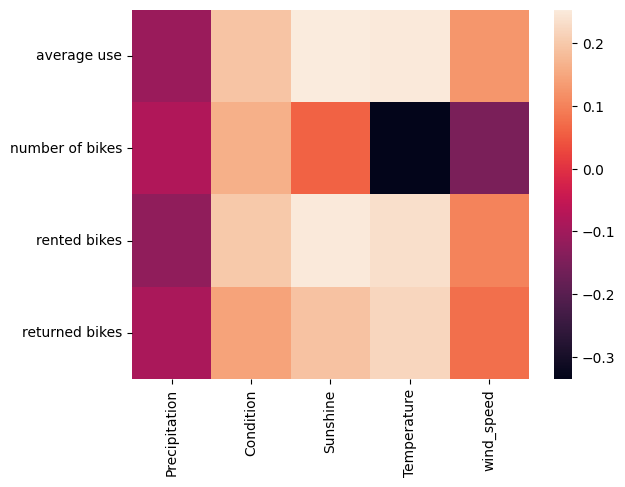

In [ ]:
#observe the correlation between the five weather attributes and the four sprottenflotte attributes
w_and_sf_no_time = weather_and_sf_day.drop(columns= ['timestamp'])
correl = w_and_sf_no_time.corr()
correl2 = correl.iloc[5:, 0:5]
sns.heatmap(correl2)

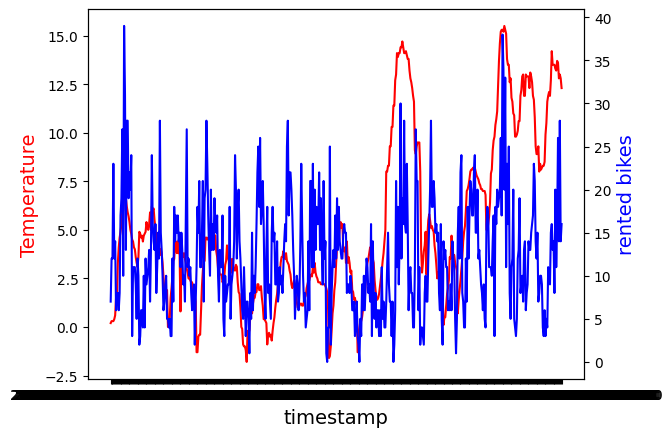

In [ ]:
make_a_plot('Temperature', 'rented bikes', weather_and_sf_day)

We want to apply Clustering on weather and sprottenflotte data. First try is without dimension reduciton before. That means we have 4 attributes of the sprottenflotte and 5 attributes of the weather. First we standardarize the data, then we try to figure out how many clusters we need and after that we apply k-means.

In [ ]:
# Standarize the weather-data
weather_and_sf_day_to_std = weather_and_sf_day.drop(columns = ['timestamp'])
weather_and_sf_day_to_std

scalar_weather_sf = StandardScaler()
scalar_weather_sf.fit(weather_and_sf_day_to_std)
weather_and_sf_day_to_std = pd.DataFrame(scalar_weather_sf.transform(weather_and_sf_day_to_std), columns = weather_and_sf_day_to_std.columns)

weather_and_sf_day_to_std.head()

,Precipitation,Condition,Sunshine,Temperature,wind_speed,average use,number of bikes,rented bikes,returned bikes
0,-0.15668,-0.997161,-0.680083,-1.144747,-0.902623,-1.090105,1.586420,-0.786536,-1.434795
1,-0.15668,-0.997161,-0.680083,-1.121243,-1.211750,-0.272391,1.412639,-0.024155,0.118080
2,-0.15668,-0.997161,-0.680083,-1.121243,-0.977240,0.000180,1.436337,-0.024155,-0.037208
3,-0.15668,-0.997161,-0.680083,-1.121243,-1.286367,1.453893,0.993985,1.653085,1.360380
4,-0.15668,-0.997161,-0.680083,-1.097738,-1.126474,0.272751,1.712806,-0.024155,1.670955


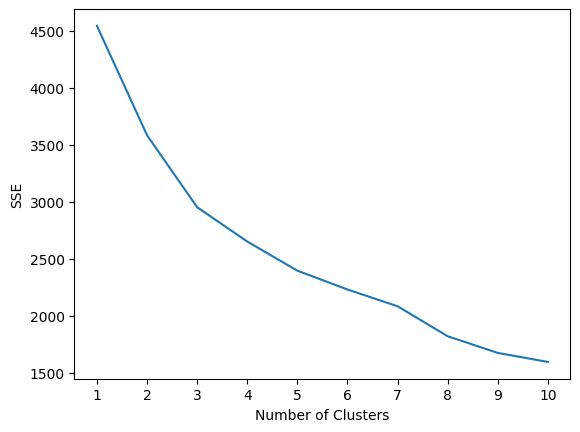

In [ ]:
#Find out how many clusters are good

# initialize kmeans parameters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1
}


# create list to hold SSE (sum of squared errors) values for each k
sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(weather_and_sf_day_to_std)
    sse.append(kmeans.inertia_)

# visualize results
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
# instantiate the k-means class, using 2 as a number of clusters
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)

# fit k-means algorithm to data
kmeans.fit(weather_and_sf_day_to_std)

# view cluster assignments for each observation
all_predictions = kmeans.predict(weather_and_sf_day_to_std)
all_predictions

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,

In [ ]:
# make a dataframe with the clusters as column
weather_and_sf_day_clustered = weather_and_sf_day_to_std[:]
weather_and_sf_day_clustered["Cluster"] = all_predictions
weather_and_sf_day_clustered.head()

,Precipitation,Condition,Sunshine,Temperature,wind_speed,average use,number of bikes,rented bikes,returned bikes,Cluster
0,-0.15668,-0.997161,-0.680083,-1.144747,-0.902623,-1.090105,1.586420,-0.786536,-1.434795,1
1,-0.15668,-0.997161,-0.680083,-1.121243,-1.211750,-0.272391,1.412639,-0.024155,0.118080,1
2,-0.15668,-0.997161,-0.680083,-1.121243,-0.977240,0.000180,1.436337,-0.024155,-0.037208,1
3,-0.15668,-0.997161,-0.680083,-1.121243,-1.286367,1.453893,0.993985,1.653085,1.360380,2
4,-0.15668,-0.997161,-0.680083,-1.097738,-1.126474,0.272751,1.712806,-0.024155,1.670955,1


In [ ]:
#plot every combination of the attributes and colour the clusters
# plot_cluster = sns.pairplot(weather_and_sf_day_clustered, hue="Cluster")
# plt_cluster.figure(figsize=(10,10))
# plt_cluster

Secondly we try to cluster after doing PCA on weather and on the sprottenflotte data to have one dimension each.

In [ ]:
# take the scaled data of weather
scaled_data_weather = weather_and_sf_day_clustered.iloc[:,0:5]
scaled_data_weather.head()

,Precipitation,Condition,Sunshine,Temperature,wind_speed
0,-0.15668,-0.997161,-0.680083,-1.144747,-0.902623
1,-0.15668,-0.997161,-0.680083,-1.121243,-1.211750
2,-0.15668,-0.997161,-0.680083,-1.121243,-0.977240
3,-0.15668,-0.997161,-0.680083,-1.121243,-1.286367
4,-0.15668,-0.997161,-0.680083,-1.097738,-1.126474


In [ ]:
#doing PCA on weather data
pca_weather = PCA(n_components = 5)
pca_weather.fit(scaled_data_weather)
data_pca_weather = pca_weather.transform(scaled_data_weather)
data_pca_weather = pd.DataFrame(data_pca_weather,columns=['PC1_weather','PC2_weather','PC3_weather', 'PC4_weather', 'PC5_weather'])
data_pca_weather.head()

,PC1_weather,PC2_weather,PC3_weather,PC4_weather,PC5_weather
0,0.341707,-1.694996,0.146663,-0.310957,-0.706107
1,0.269155,-1.887711,0.098254,-0.087525,-0.744112
2,0.326540,-1.730648,0.124990,-0.247567,-0.717558
3,0.250896,-1.937686,0.089747,-0.036603,-0.752561
4,0.293114,-1.816275,0.094810,-0.133256,-0.737459


In [ ]:
#take the standarized sf data
scaled_data_sf = weather_and_sf_day_clustered.iloc[:,5:9]
scaled_data_sf.head()

,average use,number of bikes,rented bikes,returned bikes
0,-1.090105,1.586420,-0.786536,-1.434795
1,-0.272391,1.412639,-0.024155,0.118080
2,0.000180,1.436337,-0.024155,-0.037208
3,1.453893,0.993985,1.653085,1.360380
4,0.272751,1.712806,-0.024155,1.670955


In [ ]:
#PCA on sf
pca_sf = PCA(n_components = 4)
pca_sf.fit(scaled_data_sf)
data_pca_sf = pca_sf.transform(scaled_data_sf)
data_pca_sf = pd.DataFrame(data_pca_sf,columns=['PC1_sf','PC2_sf','PC3_sf', 'PC4_sf'])
data_pca_sf.head()

,PC1_sf,PC2_sf,PC3_sf,PC4_sf
0,-2.140004,1.242204,0.495662,-0.118181
1,-0.338936,1.385878,-0.069727,0.209465
2,-0.265824,1.409605,0.044965,-0.073215
3,2.382388,1.395292,0.233276,0.090028
4,0.798010,1.910302,-1.161557,0.406800


In [ ]:
#prepare a dataframe to do PCA
weather_dim_red_df = data_pca_weather[['PC1_weather']]
sf_dim_red_df = data_pca_sf[['PC1_sf']]

PC1_list = sf_dim_red_df['PC1_sf'].to_list()

weather_and_sf_1PC = weather_dim_red_df[:]
weather_and_sf_1PC = weather_and_sf_1PC.assign(PC1_sf = PC1_list)
weather_and_sf_1PC.head()

,PC1_weather,PC1_sf
0,0.341707,-2.140004
1,0.269155,-0.338936
2,0.326540,-0.265824
3,0.250896,2.382388
4,0.293114,0.798010


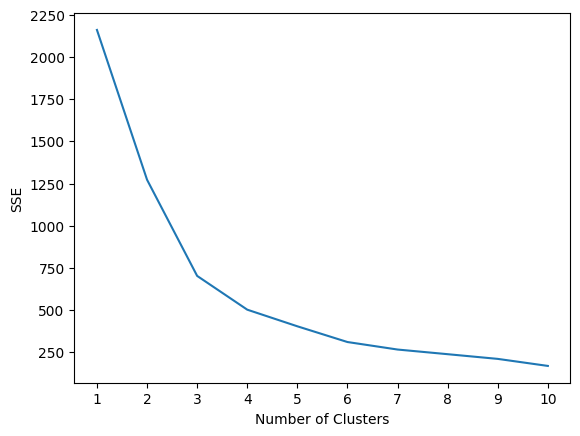

In [ ]:
#Finding out how many clusters

# initialize kmeans parameters
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1
}


# create list to hold SSE (sum of squared errors) values for each k
sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(weather_and_sf_1PC)
    sse.append(kmeans.inertia_)

# visualize results
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
#applying k-means Clustering on the data

# instantiate the k-means class, using 4 as a number of clusters
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)

# fit k-means algorithm to data
kmeans.fit(weather_and_sf_1PC)

# view cluster assignments for each observation
all_predictions_after_PCA = kmeans.predict(weather_and_sf_1PC)
all_predictions_after_PCA

array([2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1,
       2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0,

<module 'matplotlib.pyplot' from 'c:\\Users\\a-c-g\\Informatik\\DS\\data-science-projekt\\sprottenflotte_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

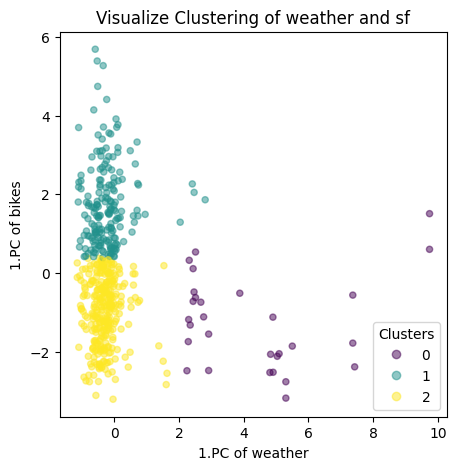

In [ ]:
# pllotting the clustering after PCA
X = weather_and_sf_1PC["PC1_weather"]
Y = weather_and_sf_1PC["PC1_sf"]

plt.figure(figsize=(5,5))
scatter = plt.scatter(X, Y, c=all_predictions_after_PCA, s=20, alpha=0.5)
legend = plt.legend(*scatter.legend_elements(), loc="lower right", title="Clusters")
plt.title("Visualize Clustering of weather and sf")
plt.xlabel("1.PC of weather")
plt.ylabel("1.PC of bikes")
plt.dist = 10
plt

Watching the 1.PC of the weather together with the 1.PC of the Sprottenflotte/ with the number of rented bikes.

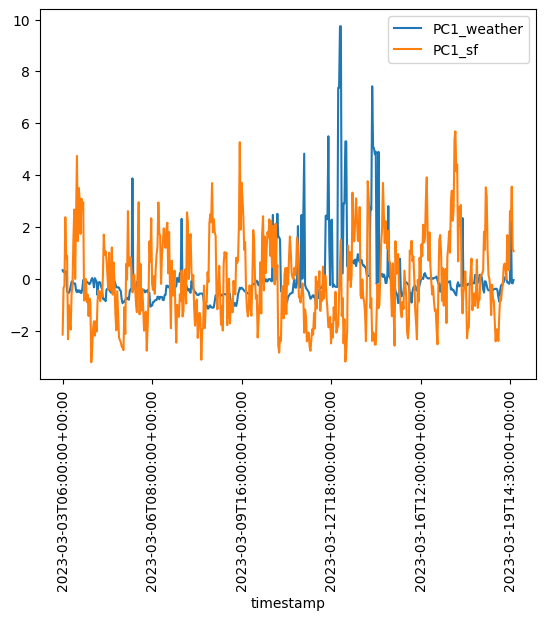

In [ ]:
#make a dataframe with the two 1. PCs and the timestamp to visualize them
weatherPC_sf_PC_time = weather_and_sf_1PC[:]
weatherPC_sf_PC_time['timestamp'] = (weather_and_sf_day['timestamp']).to_list()
weatherPC_sf_PC_time

#make the plot
axes = plt.gca()
plot_PC = weatherPC_sf_PC_time.plot(x='timestamp', y='PC1_weather', ax = axes)
plot_PC = weatherPC_sf_PC_time.plot(x='timestamp', y='PC1_sf', ax = axes)
plot_PC.tick_params(axis = 'x',rotation=90)

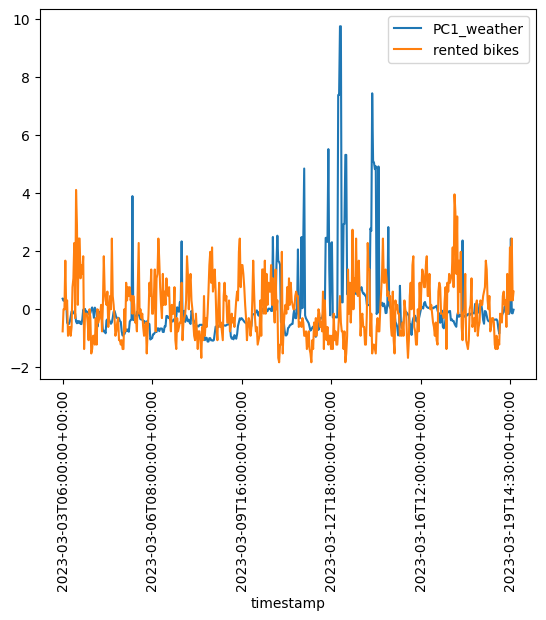

In [ ]:
weatherPC_sf_PC_time_and_rented = weatherPC_sf_PC_time[:]
weatherPC_sf_PC_time_and_rented['rented bikes'] = (weather_and_sf_day_to_std['rented bikes']).to_list()
weatherPC_sf_PC_time

axes = plt.gca()
plot_test = weatherPC_sf_PC_time_and_rented.plot(x='timestamp', y='PC1_weather', ax = axes)
plot_test = weatherPC_sf_PC_time_and_rented.plot(x='timestamp', y='rented bikes', ax = axes)
plot_test.tick_params(axis = 'x',rotation=90)

Now we want to make predicitons of the Sprottenflotte numbers based on the weather data. We decided to predict the number of 'rented bikes' of the Sprottenflotte-data, because it might be the most interesting value for the real world (e.g. you could give hints where should be how many bikes if a certain weather is predicted).
We start with a linear regression. An advantage is that we can predict numerical data which is what we got. Disadvantage is that it is hard to predict for few input data.

In [ ]:
# We use this dataframe:
weather_and_sf_day.head()

,timestamp,Precipitation,Condition,Sunshine,Temperature,wind_speed,average use,number of bikes,rented bikes,returned bikes
0,2023-03-03T06:00:00+00:00,0.0,3,0.0,0.2,9.7,89,448.000000,7,3
1,2023-03-03T06:30:00+00:00,0.0,3,0.0,0.3,6.8,98,444.333333,12,13
2,2023-03-03T07:00:00+00:00,0.0,3,0.0,0.3,9.0,101,444.833333,12,12
3,2023-03-03T07:30:00+00:00,0.0,3,0.0,0.3,6.1,117,435.500000,23,21
4,2023-03-03T08:00:00+00:00,0.0,3,0.0,0.4,7.6,104,450.666667,12,23


Linear Regression:


[-18.34885512   1.10684812   0.10558217   0.29122553   0.04586652]
4.6611549780722195
 Accuracy of the model is 16.21


(0.5499999999999998, 32.45, 3.046808934435241, 18.196877344418596)

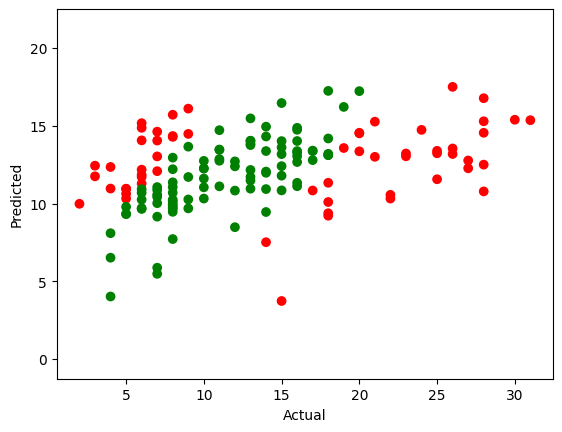

In [ ]:
# input data X are the weather attributes, and output data the rented bikes
X = weather_and_sf_day.iloc[:, 1:6]
Y = weather_and_sf_day.iloc[:, 8]

# split the data in test and train data
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=20)

# train the model
linreg = LinearRegression()
linreg.fit(X_train, Y_train)

# predict the target values for the test set
Y_pred = linreg.predict(X_test)

# Coefficient and Intercept of the model
print(linreg.coef_)
print(linreg.intercept_)

# Print the accuracy which is an indicator for the quality of the model
Accuracy=r2_score(Y_test,Y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

# plot the acutal and predicted value of the test set
# the green dots are well predicted values
filter = np.where(abs(Y_test - Y_pred) < 5, 'g', 'r')
plt.scatter(x = Y_test,y = Y_pred, c = filter)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

Linear Regression with normalized data:
(no differences in prediciton)

 Accuracy of the model is 16.65


(-1.785161427056076,
 3.5118055063180558,
 -1.3006271799605091,
 1.0432095711192442)

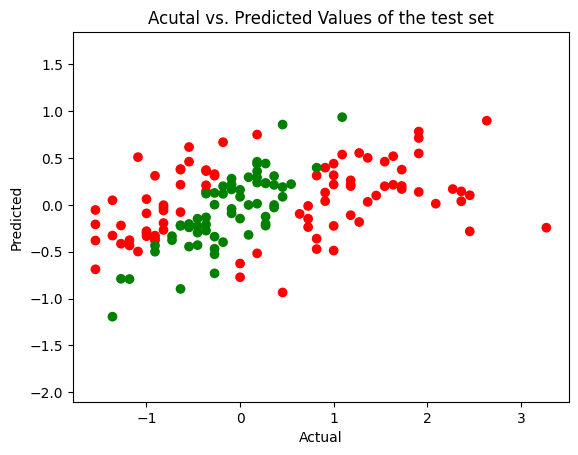

In [ ]:
norm = weather_and_sf_day_to_std[:]
x = norm.iloc[:, 0:5]
y = norm.iloc[:, 5]

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 20)


linreg=LinearRegression()
linreg.fit(x_train,y_train)
y_pred = linreg.predict(x_test)


Accuracy=r2_score(y_test,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

filter = np.where(abs(y_test - y_pred) < 0.5, 'g', 'r')
plt.scatter(y_test, y_pred, c = filter)
plt.title('Acutal vs. Predicted Values of the test set')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')


Many prediciton methods predict classes. So we make some classes. Therefore we watch the distribution of the rented bikes.

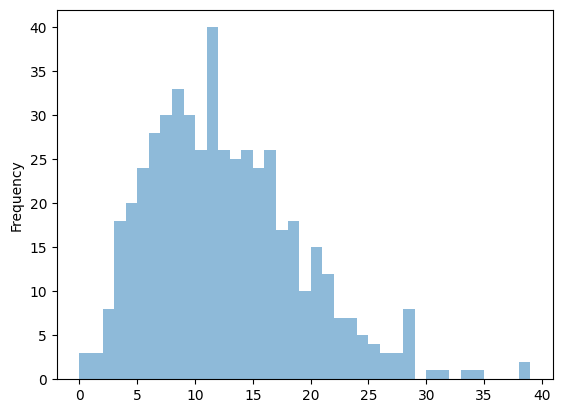

In [ ]:
ax = weather_and_sf_day['rented bikes'].plot.hist(bins=39, alpha=0.5)

Five classes are very difficult to predict with few data. That's why we decide for three classes.

Make a new dataframe which includes the classes of the number of rented bikes based on the function 'make_three_classes_of_rented'.

In [ ]:
# new dataframe with a new column of the classes 
df_with_classes = weather_and_sf_day[:]
df_with_classes['rented bikes class'] = df_with_classes['rented bikes'].apply(make_three_classes_of_rented)
df_with_classes

,timestamp,Precipitation,Condition,Sunshine,Temperature,wind_speed,average use,number of bikes,rented bikes,returned bikes,rented bikes class
0,2023-03-03T06:00:00+00:00,0.0,3,0.0,0.2,9.7,89,448.000000,7,3,normal
1,2023-03-03T06:30:00+00:00,0.0,3,0.0,0.3,6.8,98,444.333333,12,13,normal
2,2023-03-03T07:00:00+00:00,0.0,3,0.0,0.3,9.0,101,444.833333,12,12,normal
3,2023-03-03T07:30:00+00:00,0.0,3,0.0,0.3,6.1,117,435.500000,23,21,high
4,2023-03-03T08:00:00+00:00,0.0,3,0.0,0.4,7.6,104,450.666667,12,23,normal
...,...,...,...,...,...,...,...,...,...,...,...
500,2023-03-19T14:30:00+00:00,0.0,4,0.0,13.6,10.8,114,382.500000,26,18,high
501,2023-03-19T15:00:00+00:00,0.0,1,0.0,12.8,8.3,112,382.833333,14,27,normal
502,2023-03-19T15:30:00+00:00,0.0,4,0.0,13.0,8.3,122,383.666667,28,22,high
503,2023-03-19T16:00:00+00:00,0.0,4,0.0,12.8,8.3,108,386.166667,14,17,normal


Prediciton with classes.

Gaussian Naive Bayes:

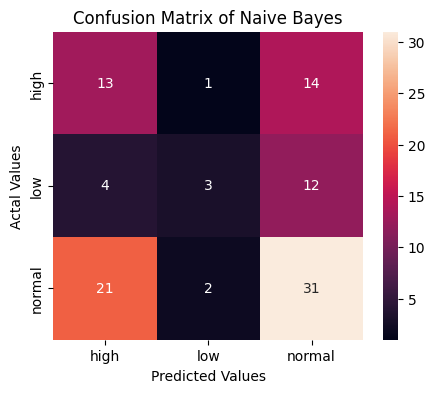

 Accuracy of the model is 0.47
              precision    recall  f1-score   support

        high       0.46      0.34      0.39        38
         low       0.16      0.50      0.24         6
      normal       0.57      0.54      0.56        57

    accuracy                           0.47       101
   macro avg       0.40      0.46      0.40       101
weighted avg       0.51      0.47      0.48       101

Confusion matrix:
[[13  1 14]
 [ 4  3 12]
 [21  2 31]]


In [ ]:
# input data X are the weather attributes, and output data the rented bikes
X2 = df_with_classes.iloc[:, 1:6]
Y2 = df_with_classes.iloc[:,10]

# split the data in test and train data
X2train, X2test, Y2train, Y2test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

#train the model 
modelGauss = GaussianNB().fit(X2train, Y2train)

# predict the target values for the test set
Y2pred = modelGauss.predict(X2test)

#labels for the confusion matrix are the names of the classes
labels = modelGauss.classes_

# Make the confusion matrix
cm = confusion_matrix(Y2test, Y2pred)
cm_df = pd.DataFrame(cm, labels, labels)

# Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix of Naive Bayes')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Evaluate the quality of the model:
report = classification_report(Y2pred, Y2test)
accuracy = accuracy_score(Y2test, Y2pred)
print(" Accuracy of the model is %.2f" %accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Decision Tree:

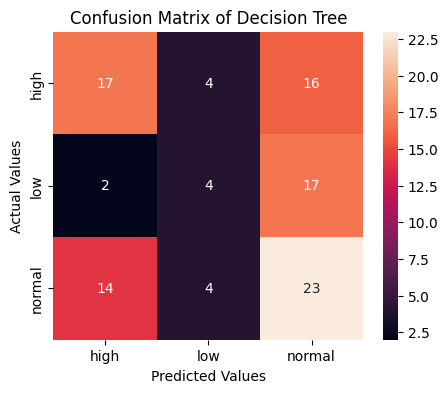

 Accuracy of the model is 0.44
              precision    recall  f1-score   support

        high       0.46      0.52      0.49        33
         low       0.17      0.33      0.23        12
      normal       0.56      0.41      0.47        56

    accuracy                           0.44       101
   macro avg       0.40      0.42      0.40       101
weighted avg       0.48      0.44      0.45       101

Confusion matrix:
[[17  4 16]
 [ 2  4 17]
 [14  4 23]]


In [ ]:
# input data X are the weather attributes, and output data the rented bikes
x = df_with_classes.iloc[:,1:6]
y = df_with_classes.iloc[:,10]

# split the data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

# train the model 
clf = DecisionTreeClassifier().fit(X_train,y_train)

# predict the target values for the test set
y_pred = clf.predict(X_test)

#labels for the confusion matrix are the names of the classes
labels = clf.classes_

# Make the confusion matrix
cm1 = confusion_matrix(y_test, y_pred)
cm1_df = pd.DataFrame(cm1, labels, labels)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm1_df, annot=True)
plt.title('Confusion Matrix of Decision Tree')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Evaluate the quality of the model
report = classification_report(y_pred, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(" Accuracy of the model is %.2f" %accuracy)
print(report)
print("Confusion matrix:")
print(cm1)

Random Forest:

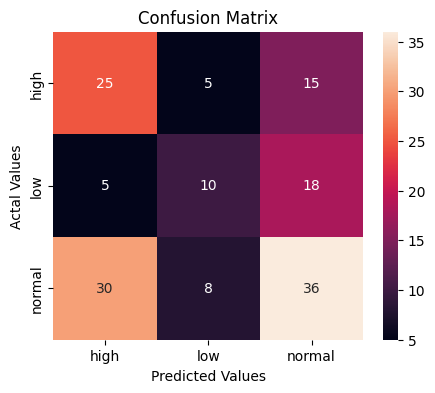

 Accuracy of the model is 0.47
              precision    recall  f1-score   support

        high       0.56      0.42      0.48        60
         low       0.30      0.43      0.36        23
      normal       0.49      0.52      0.50        69

    accuracy                           0.47       152
   macro avg       0.45      0.46      0.45       152
weighted avg       0.49      0.47      0.47       152

Confusion matrix of the Random Forest:
[[25  5 15]
 [ 5 10 18]
 [30  8 36]]


In [ ]:
# input data X are the weather attributes, and output data the rented bikes
x = df_with_classes.iloc[:,1:6]
y = df_with_classes.iloc[:,10]

# split the data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# train the model 
rf = RandomForestClassifier(max_depth=20, random_state=0)

rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

labels = rf.classes_

#Make a confusion matrix
cm2 = confusion_matrix(y_test, y_pred)
cm2_df = pd.DataFrame(cm2, labels, labels)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm2_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#Evaluate the quality of the modle 
report = classification_report(y_pred, y_test)
accuracy = accuracy_score(y_test, y_pred)
print(" Accuracy of the model is %.2f" %accuracy)
print(report)
print("Confusion matrix of the Random Forest:")
print(cm2)

Because the Random Forest worked the best for our data, we use it to make predictions for new inputs of weather:

In [ ]:
# Example of a preciction with 'good' weather: no precipitation, dry condition, full sunshine, high temperature (for this timeslot), no wind
make_a_prediction(0,4,30,2,0,rf)

'high'

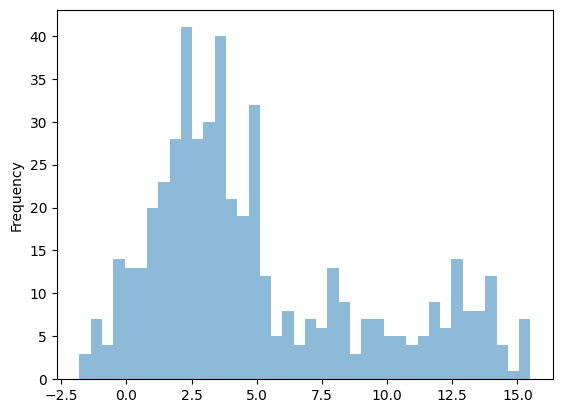

In [ ]:
#plot the distribution of the wind_speed to find ranges
ax = weather_and_sf_day['Temperature'].plot.hist(bins=40, alpha=0.5)

Make a function that simplifies the function 'make_a_prediction' to give the user a limited amount of describing the weather.

In [ ]:
#Categories:
# sun: yes,no
# precipitation: no, rain, snow
# wind: low, middle, high
# temperature: negativ, positiv

#example for 'good' weather : no precipiation, low wind, positive temperatures and sun
make_a_prediction_categories(('rain', 'high', 'negative', 'no'), rf)

'low'

Prepare the results to use them on the website.

In [ ]:
#list of all possible category-combination:
categories = {'Precipitation': ['nothing', 'rain', 'snow'], 'Wind':['low', 'middle', 'high'], 'Temperature':['negative', 'positive'], 'Sunshine': ['no','yes'],}

list_of_categories = [ ['nothing', 'rain', 'snow'], ['low', 'middle', 'high'], ['negative', 'positive'], ['yes', 'no']]

list_of_combinations = [p for p in itertools.product(*list_of_categories)]

dict_of_predicitons = {}

# make the combinations to a string to use it as a key in a json
for weather in list_of_combinations:
     weather_bit = ''
     for elem in weather:
          if elem =='no' or elem == 'nothing' or elem == 'low' or elem =='negative':
               weather_bit += '0'  
          elif elem == 'yes' or elem == 'rain' or elem == 'middle' or elem == 'positive':
               weather_bit += '1'
          else:
               weather_bit += '2'
     dict_of_predicitons[weather_bit] = make_a_prediction_categories(weather, rf)

dict_of_predicitons

{'0001': 'high',
 '0000': 'normal',
 '0011': 'high',
 '0010': 'normal',
 '0101': 'high',
 '0100': 'normal',
 '0111': 'high',
 '0110': 'low',
 '0201': 'high',
 '0200': 'normal',
 '0211': 'high',
 '0210': 'low',
 '1001': 'low',
 '1000': 'low',
 '1011': 'low',
 '1010': 'low',
 '1101': 'low',
 '1100': 'low',
 '1111': 'low',
 '1110': 'low',
 '1201': 'low',
 '1200': 'low',
 '1211': 'high',
 '1210': 'normal',
 '2001': 'low',
 '2000': 'low',
 '2011': 'low',
 '2010': 'low',
 '2101': 'low',
 '2100': 'low',
 '2111': 'low',
 '2110': 'low',
 '2201': 'low',
 '2200': 'low',
 '2211': 'high',
 '2210': 'normal'}

In [ ]:
#save as json file
with open('prediciton2.json', 'w') as fp:
    json.dump(dict_of_predicitons, fp)

Predict the numbers per station. 

In [ ]:
# make new columns in the weather data for the bike data for a certain station
weather_and_sf_day_per_station = weather_and_sf_day_original[:]

Now we consider a time slot of 3 hours, because the numbers of rented bikes per half hour at just one station are too small.

Try some Prediction/classifier models.

In [ ]:
df_station = make_dataframe_of_weather_and_sf_per_station(24413, weather_and_sf_day_per_station, dict_of_renting)
small_df = make_a_df_with_blocks_3_hours(df_station)
df_with_classes_per_station = small_df[:]
df_with_classes_per_station['rented bikes class'] = df_with_classes_per_station['rented'].apply(make_three_classes_of_rented_per_station)
df_with_classes_per_station.head()

,Preci,Cond,Sun,Temp,wind,rented,rented bikes class
0,0.0,3,0.000000,0.514286,8.171429,2,a few times
1,0.0,4,1.142857,4.242857,15.885714,4,more often
2,0.0,4,26.428571,6.257143,25.928571,2,a few times
3,0.0,4,7.000000,4.600000,22.785714,5,more often
4,0.0,4,0.285714,3.985714,21.400000,7,more often


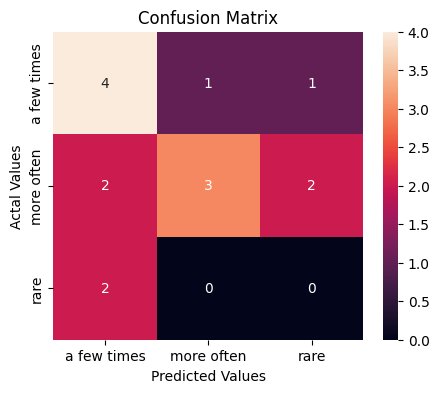

 Accuracy of the model is 0.47
              precision    recall  f1-score   support

 a few times       0.67      0.50      0.57         8
  more often       0.43      0.75      0.55         4
        rare       0.00      0.00      0.00         3

    accuracy                           0.47        15
   macro avg       0.37      0.42      0.37        15
weighted avg       0.47      0.47      0.45        15

Confusion matrix:
[[4 1 1]
 [2 3 2]
 [2 0 0]]


In [ ]:
#Random Forest/ Decision Tree
xs = df_with_classes_per_station.iloc[:,0:5]
ys = df_with_classes_per_station.iloc[:,6]

Xs_train, Xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.2, random_state=0)

rfs = DecisionTreeClassifier()
#rfs = RandomForestClassifier(max_depth=3, random_state=42)
rfs = rfs.fit(Xs_train, ys_train)
ys_pred = rfs.predict(Xs_test)

labels2 = rfs.classes_

#Evaluation
report = classification_report(ys_pred, ys_test)
cms = confusion_matrix(ys_test, ys_pred)
cms_df = pd.DataFrame(cms,labels2, labels2)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cms_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# print("Classification report:")
accuracy = accuracy_score(y_test, y_pred)
print(" Accuracy of the model is %.2f" %accuracy)
print(report)
print("Confusion matrix:")
print(cms)

 Accuracy of the model is 8.17


(-0.35000000000000003, 7.35, 2.6174858456988686, 4.167542851769241)

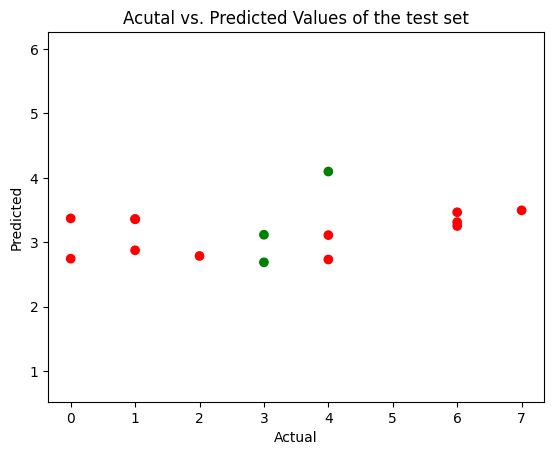

In [ ]:
#Poisson Regression
xs = df_with_classes_per_station.iloc[:,0:5]
ys = df_with_classes_per_station.iloc[:,5]

Xs_train, Xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.2, random_state=0)

rfs = PoissonRegressor()
rfs.fit(Xs_train, ys_train)

ys_pred = rfs.predict(Xs_test)


Accuracy=r2_score(ys_test,ys_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

filter = np.where(abs(ys_test - ys_pred) < 0.5, 'g', 'r')
plt.scatter(ys_test, ys_pred, c = filter)
plt.title('Acutal vs. Predicted Values of the test set')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axis('equal')

In [ ]:
#list of the stations in kiel
kiel_station = [24371, 24384, 24468, 24385, 26209, 26224, 26262, 24412, 24376,
       24397, 24383, 24387, 24413, 24389, 24466, 24398, 24380, 24401,
       24454, 24375, 24480, 24381, 24436, 24476, 24399, 24447, 24400,
       24378, 24370, 24407, 24394, 24453, 24392, 24391, 24477, 24415,
       24395, 24406, 24408, 24474, 24382, 24367, 24473, 24386, 24388,
       24405, 24410, 24404, 24414, 24442, 24440, 24448, 24449, 24469,
       24368, 24393, 24409, 24373, 24390, 24411, 24441, 24417, 24377,
       24419, 24403, 24369, 24374, 24481, 24450, 24379, 24471, 24372,
       24465, 24467, 24396, 24457, 24416, 24402]

In [ ]:
dict1 = make_predi_for_all_stations((0,4,30,2,0), weather_and_sf_day_per_station, dict_of_renting)
dict1
#für alle stations
#Preci	Cond	Sun	Temp	wind

In [ ]:
#Categories:

# precipitation: nothing, rain, snow
# wind: low, middle, high
# temperature: negativ, positiv
# sun: yes, no

#example for 'good' weather : no precipiation, low wind, positive temperatures and sun
#dict1 = make_a_prediction_categories_stations(('nothing','low' 'positive', 'yes'), weather_and_sf_day_per_station, dict_of_renting)
#dict1

In [ ]:
prediciton_list = []

for st in kiel_station:
    prediciton_list += [dict1[st]]
    
prediciton_list

In [ ]:
#dataframe with information about the stations in kiel and the prediciton for this stations
df_kiel_stations = pd.DataFrame({"stations" : kiel_station})
df_kiel_stations['prediction'] = prediciton_list
df_kiel_stations = df_kiel_stations.merge(sf_names_df, left_on = "stations", right_on = "Station_ID")

df_kiel_stations['predicted class'] = df_kiel_stations['prediction']
df_kiel_stations['predicted class'] = df_kiel_stations['predicted class'].apply(make_three_classes_of_rented_per_station)

df_kiel_stations.head()

,stations,prediction,Unnamed: 0,Station_ID,name,lat,lon,region_id,address,post_code,predicted class
0,24371,5,27,24371,Anleger Reventlou,54.333833,10.152250,866,",",NaN,more often
1,24384,1,37,24384,CAU Universitätsbibliothek,54.346612,10.112408,866,",",NaN,a few times
2,24468,0,30,24468,Catharinenberg,54.264403,10.065600,866,NaN,NaN,rare
3,24385,3,19,24385,Dreiecksplatz,54.328528,10.134417,866,",",NaN,a few times
4,26209,0,42,26209,Kanalfähre Holtenau,54.368794,10.133953,866,NaN,NaN,rare


Map the results for one certain weather conditions for all stations on a map.

In [ ]:
# access Token
mapbox_access_token = open(".mapbox_token").read()

# Create a plotly map and add the station points to the map
fig = go.Figure()

gb = df_kiel_stations.groupby(['predicted class'])
group_name = ['rare', 'a few times', 'more often']

# make groups of low, middle and high usage
my_gr_rare = gb.get_group('rare')
my_gr_few = gb.get_group('a few times')
my_gr_often = gb.get_group('more often')

fig.add_trace(go.Scattermapbox(
    lat = my_gr_rare.lat,
    lon = my_gr_rare.lon,
    mode = "markers",
    marker = {'size': 9, 'color': '#FF6347' , 'opacity': 1},
    text = my_gr_rare.name,
    name =  'rare',
    customdata = my_gr_rare.prediction,
    hovertemplate = 'Station name: %{text}'
                    + '<br>Rented bikes: %{customdata}',
    )
)

fig.add_trace(go.Scattermapbox(
    lat = my_gr_few.lat,
    lon = my_gr_few.lon,
    mode = "markers",
    marker = {'size': 13, 'color': '#db9833' , 'opacity': 1},
    text = my_gr_few.name,
    name =  'a few times',
    customdata = my_gr_few.prediction,
    hovertemplate = 'Station name: %{text}'
                    + '<br>Rented bikes: %{customdata}',
    )
)
    
fig.add_trace(go.Scattermapbox(
    lat = my_gr_often.lat,
    lon = my_gr_often.lon,
    mode = "markers",
    marker = {'size': 18, 'color': '#42b883', 'opacity': 1},
    text = my_gr_often.name,
    name =  'more often',
    customdata = my_gr_often.prediction,
    hovertemplate = 'Station name: %{text}'
                    + '<br>Rented bikes: %{customdata}',
    )
)


fig.update_layout(
    title = "Number of rented bikes based on weather",
    autosize = True,
    hovermode = "closest",
    showlegend = True,
    mapbox = dict(
        accesstoken = mapbox_access_token,
        center = dict(
            lat = 54.332111,
            lon = 10.134417,             
            ),
        zoom = 12,
        style = "light"
        ),
    width = 500,
    height = 500,
    margin = dict(l=0, r=0, b=0, t=0),
    legend = dict(bordercolor='rgb(100,100,100)',
                                borderwidth=2,
                                x=0,
                                y=1)
)

#plotly.offline.plot(fig, filename = 'sun_low.html')
fig.show()